In [3]:
from TradingBot.utils.data import get_data

In [4]:
from distfit import distfit

In [5]:
import matplotlib.pyplot as plt

In [6]:
data = get_data(tiker='TQQQ', start='2022-10-05', end="2022-10-06", which="Close", interval='1m', premarket=True)

In [7]:
from TradingBot.strategy.backtest import BackTest

In [10]:
from pytz import timezone

In [11]:
def convertdata_yfinance(yfi_data):
    '''
    use open during eval
    
    '''
    def convert_time(row):
        nyc = timezone('America/New_York')
        return row['Date'].to_pydatetime().astimezone(nyc)
    
    yfi_data['time'] = yfi_data.apply(lambda row: convert_time(row), axis=1)
    yfi_data.rename(columns={'Open':'price'}, inplace=True)
    return yfi_data[['time', 'price', 'pct_change']]

In [12]:
data = convertdata_yfinance(data)

In [14]:


from TradingBot.strategy.momentum import Momentum

In [18]:

class Momentum_settings:
    '''
    if you found it is more likely to enter "long stage"
        - you should set higher threshold for short, but lower threshold for long
    '''
    long_buy_thres = 0
    long_sell_thres = 0
    short_buy_thres = 0
    short_sell_thres = 0
    slow_smooth_factor = 20 # long-term indicator as ema smooth factor
    # if larger, slower track of current price, more consistent
    fast_smooth_factor = 5 # price smooth factor for computing momentum


mo1 = Momentum(data, Momentum_settings())

In [20]:
mo1.signal_df

,time,price,pct_change,ema,smoothed_pct_change,signal
0,2022-10-05 04:00:00-04:00,22.25,NaN,22.250000,NaN,empty
1,2022-10-05 04:01:00-04:00,22.14,0.001355,22.239524,0.001355,empty
2,2022-10-05 04:02:00-04:00,22.17,0.000451,22.232902,0.000813,empty
3,2022-10-05 04:03:00-04:00,22.18,-0.001803,22.227864,-0.000427,short
4,2022-10-05 04:04:00-04:00,22.14,0.000903,22.219496,0.000126,empty
...,...,...,...,...,...,...
942,2022-10-05 19:55:00-04:00,22.89,0.001749,22.771487,0.000944,long
943,2022-10-05 19:56:00-04:00,22.90,-0.000476,22.783727,0.000471,long
944,2022-10-05 19:57:00-04:00,22.90,-0.000834,22.794800,0.000036,long
945,2022-10-05 19:58:00-04:00,22.88,0.001748,22.802915,0.000607,long


In [13]:
data['smoothed_pct_change'] = data['pct_change'].ewm(span=3, min_periods=1).mean()

In [16]:
import numpy as np

In [22]:
new = np.nan_to_num(data['smoothed_pct_change'].values, nan=0)

In [6]:
sig = data['Close'].diff().values
sig = sig[1:]

[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[norm      ] [0.00 sec] [RSS: 35.7767] [loc=0.001 scale=0.033]
[distfit] >[expon     ] [0.00 sec] [RSS: 1034.73] [loc=-0.250 scale=0.251]
[distfit] >[pareto    ] [0.06 sec] [RSS: 1035.97] [loc=-200321.315 scale=200321.065]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 288.936] [loc=-0.000 scale=0.022]
[distfit] >[t         ] [0.02 sec] [RSS: 23.0509] [loc=0.001 scale=0.024]
[distfit] >[genextreme] [0.11 sec] [RSS: 1046.36] [loc=-0.020 scale=0.215]
[distfit] >[gamma     ] [0.04 sec] [RSS: 66.3223] [loc=-0.931 scale=0.001]
[distfit] >[lognorm   ] [0.09 sec] [RSS: 36.3664] [loc=-10.681 scale=10.681]
[distfit] >[beta      ] [0.08 sec] [RSS: 33.6451] [loc=-7.957 scale=8.837]
[distfit] >[uniform   ] [0.00 sec] [RSS: 851.09] [loc=-0.250 scale=0.400]
[distfit] >[loggamma  ] [0.02 sec] [RSS: 32.8027] [loc=-1.678 scale=0.354]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


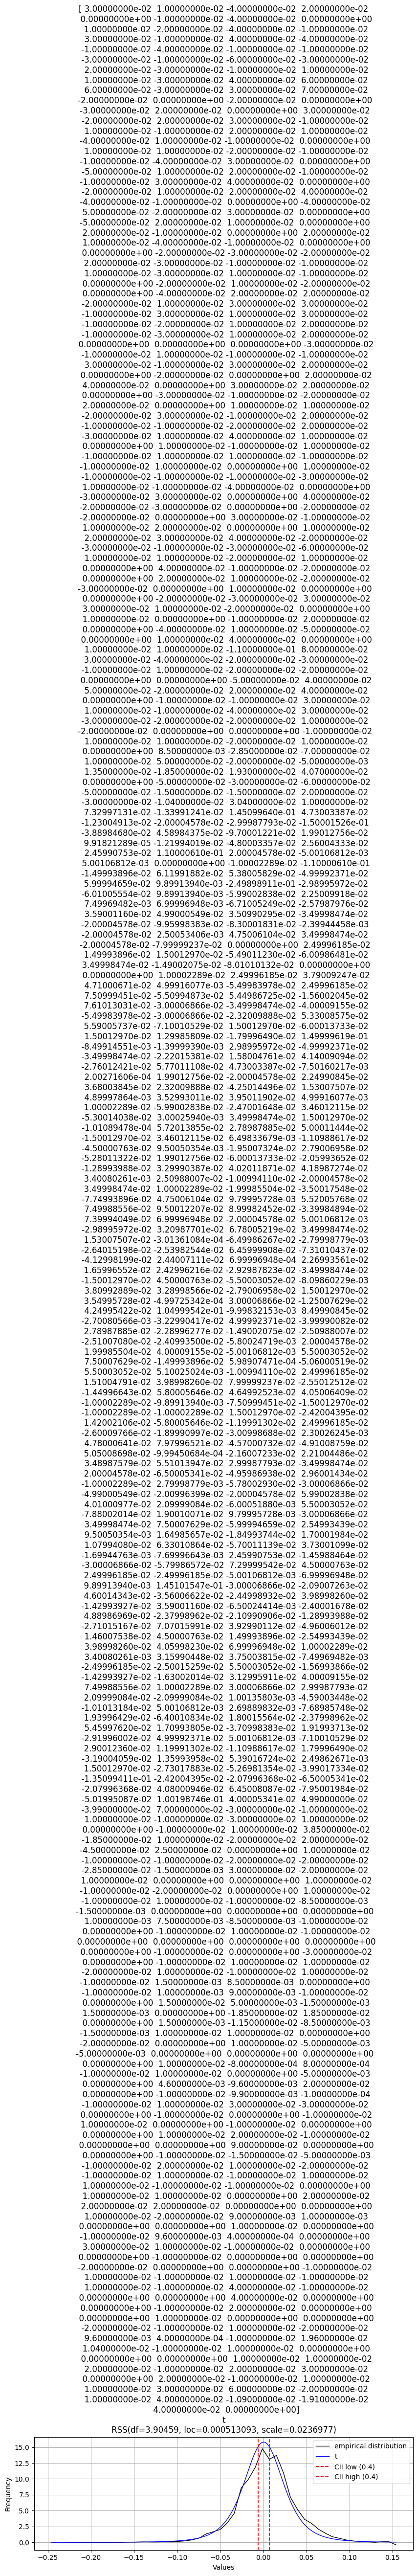

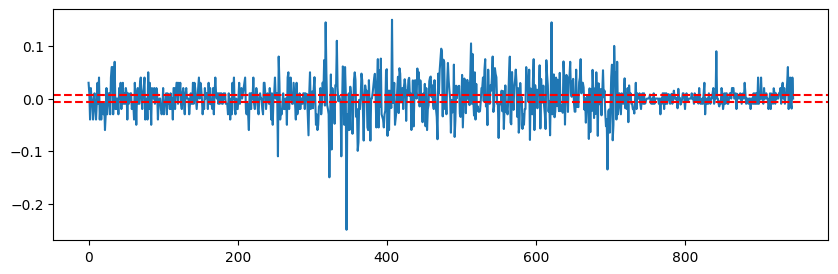

In [ ]:
filter_central_prob = 0.2

dist = distfit(alpha=(1-filter_central_prob)/2, smooth=4)

dist.fit_transform(sig)
dist.plot(sig, figsize=(10, 3))
# Search for best theoretical fit on your empirical data

plt.figure(figsize=(10, 3))
plt.plot(sig)
plt.axhline(dist.model['CII_min_alpha'], linestyle='--', c='r', label='CII low')
plt.axhline(dist.model['CII_max_alpha'], linestyle='--', c='r', label='CII high')
